# Figure 2

Script to generate Figure 2 from [1]. This figure shows the prototype garment, sensor fibre in both pitch configurations, as well as associated gauge factor.

> [1] Brett C. Hannigan, Tyler J. Cuthbert, Chakaveh Ahmadizadeh, and Carlo Menon. Distributed Sensing Along Fibres for Smart Clothing. *Science Advances*. 2023 (In Review).

©2023 ETH Zurich, Brett Hannigan; D-HEST; Biomedical and Mobile Health Technology (BMHT) Lab; Carlo Menon

In [11]:
library(cowplot)
library(magick)
library(readxl)
library(ggplot2)
library(broom)
library(tidyverse)
library(ggh4x)
library(rsvg)
library(pdftools)
library(patchwork)

## Import Images

`Pose Render.png` shows a rendering of the prototype garment with the sensing fibre regions superimposed. It will be placed on the left column of Figure 2.

`Sensitivity Regions.png` shows renderings of the sensor geometric model under relaxed and strained conditions, and corresponding macro photographs of the fibre on the garment.

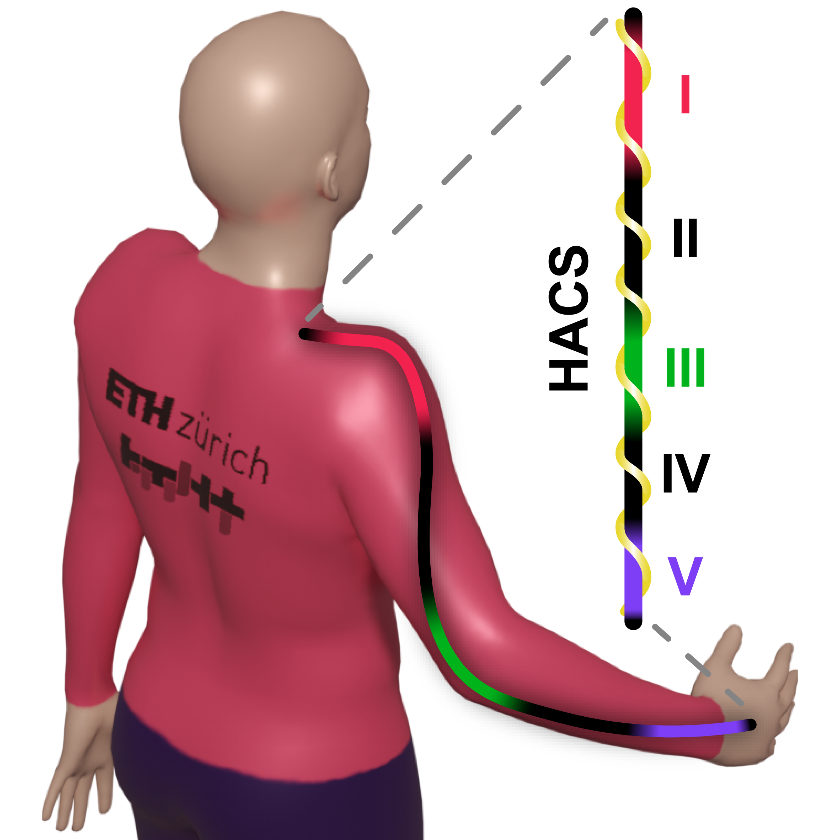

In [12]:
pose_render <- ".\\Pose Render.png"
pose_render <- ggdraw() + draw_image(pose_render, scale=1)
pose_render

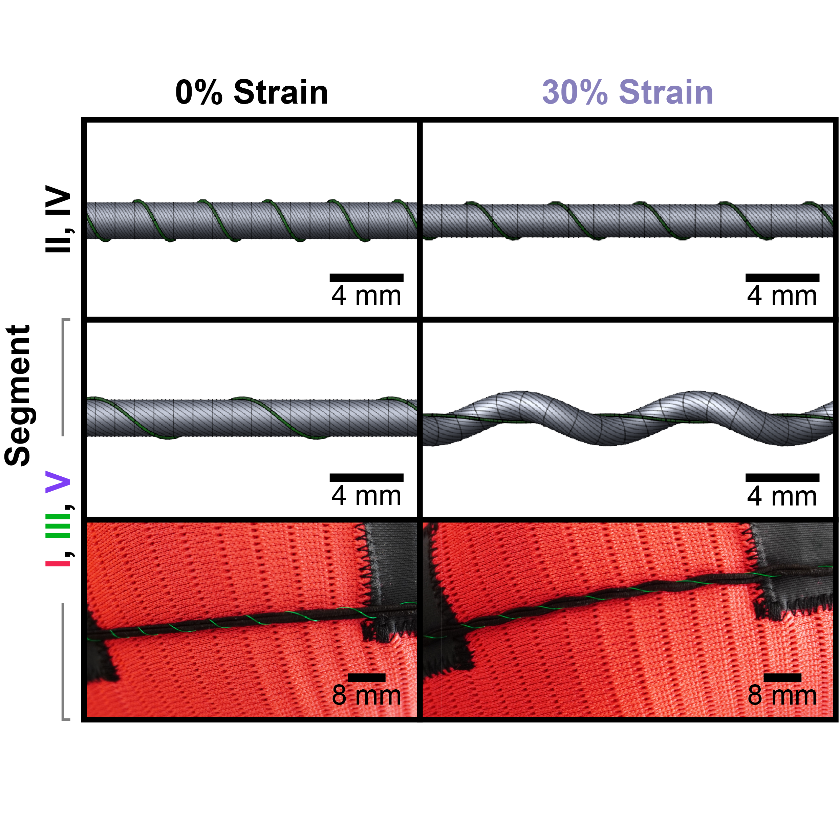

In [37]:
sensor_models <- "./Sensitivity Regions.png"
sensor_models <- ggdraw() + draw_image(sensor_models, scale=1)
sensor_models

In [15]:
#signal_strain_p3 <- read_excel(".\\E3R1H_hysteresis_graph_1.xlsx", sheet="E3R1H_10percent", range="AJ615:AO1235", col_names=c("strain", "Zmag", "Zphase", "R", "C", "dCC0"))
signal_strain_p3 <- read_excel(".\\2023-02-16T155844_E3W1-035_Run3.xlsx", range="E2:J6229", col_names=c("strain", "Zmag", "Zphase", "C", "R", "dCC0"))
#signal_strain_p8 <- read_excel(".\\E3R1H_hysteresis_graph_1.xlsx", sheet="E3R1H_10percent", range="Y2410:AD4855", col_names=c("strain", "Zmag", "Zphase", "R", "C", "dCC0"))
signal_strain_p8 <- read_excel(".\\2023-02-21T152207_Run6-85mm.xlsx", sheet="Run3", range="E2:J6225", col_names=c("strain", "Zmag", "Zphase", "C", "R", "dCC0"))
signal_strain_p3$pitch <- 3
signal_strain_p3$is.sensitive <- FALSE
signal_strain_p8$pitch <- 8
signal_strain_p8$is.sensitive <- TRUE
signal_strain <- rbind(signal_strain_p3, signal_strain_p8)

## Calculate Linear Fit (Gauge Factor)

In [16]:
from_model <- data.frame(strain=c(0.3, 0.3), dCC0=c(0.018840965, 0.3549919), pitch=c(3, 8), is.sensitive=c(FALSE, TRUE)) # See "..\2023-02-16_GFModelling\Results.xlsx"
head(from_model)
gf <- signal_strain %>%
    group_by(pitch) %>%
        group_modify(~ tidy(lm(dCC0 ~ strain, data=.))) %>%
            filter(term=='strain') %>%
                select(pitch, estimate)
gf

,strain,dCC0,pitch,is.sensitive
,<dbl>,<dbl>,<dbl>,<lgl>
1,0.3,0.01884097,3,FALSE
2,0.3,0.35499190,8,TRUE


pitch,estimate
<dbl>,<dbl>
3,0.1473385
8,1.0578874


## Produce Signal vs. Strain Graphs

These graphs will be shown with the gauge factor in the rightmost column of Figure 2.

In [17]:
signal_strain[signal_strain$pitch==3,"progress"] = seq(from=0, to=1, length.out=sum(signal_strain$pitch==3))
signal_strain[signal_strain$pitch==8,"progress"] = seq(from=0, to=1, length.out=sum(signal_strain$pitch==8))

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 188 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_path()`)."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 188 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_path()`)."


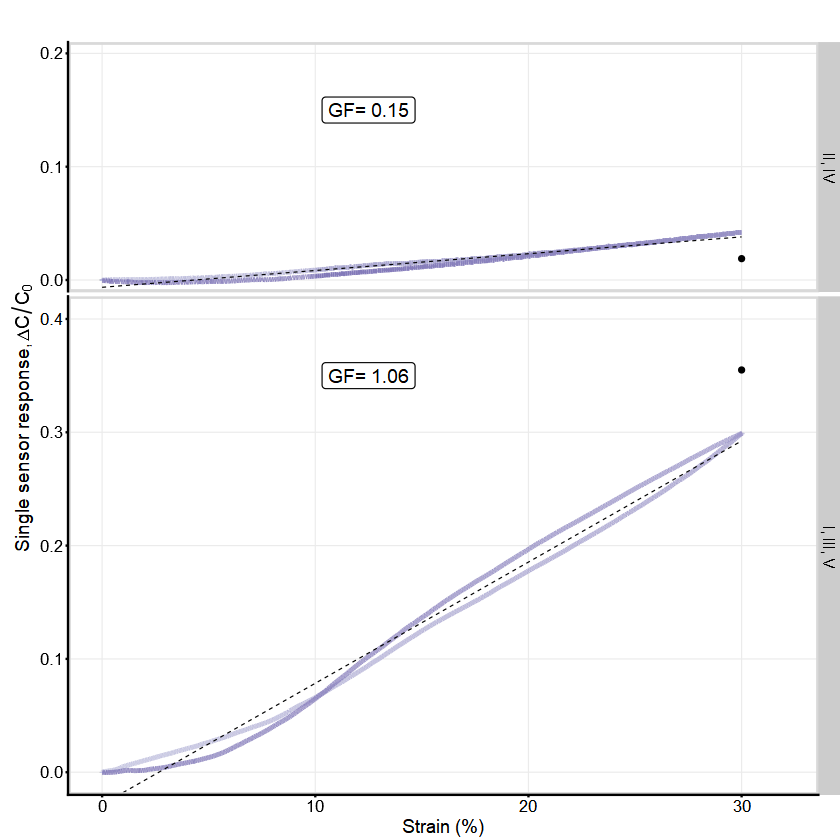

In [39]:
# sensor_label_colours <- c('#F32350', '#00B31C', '#7E3EF5', '#E62DFF')
# strip <- strip_themed(background_y = elem_list_rect(fill = sensor_label_colours))
pitch_names <- c(`3` = "II, IV", `8` = "I, III, V")
#x=0.22, y=0.08, 
plt1 <- ggplot(data=signal_strain, aes(x=strain, y=dCC0, group=as.factor(pitch), color=progress))
plt1 <- plt1 + geom_path(linewidth=1)
plt1 <- plt1 + scale_color_gradient(low='#bcbddc', high='#756bb1', name="Time", guide="none")
plt1 <- plt1 + geom_smooth(method="lm", xseq=seq(0.0, 0.3, length=100), fill=NA, colour="black", size=0.25, linetype="dashed")
#plt1 <- plt1 + scale_colour_manual(values=sensor_label_colours, guide="none")
plt1 <- plt1 + geom_point(data=from_model, mapping=aes(x=strain, y=dCC0, group=as.factor(pitch)), size=1, colour="black")
plt1 <- plt1 + geom_label(data=gf, mapping=aes(label=paste('GF=', round(estimate, 2)), x=c(0.125, 0.125), y=c(0.15, 0.35)), colour="black", size=4)
plt1 <- plt1 + ylab(expression('Single sensor response,'~Delta*C/C[0]))
plt1 <- plt1 + xlab(expression('Strain (%)'))
#plt1 <- plt1 + coord_equal()
plt1 <- plt1 + facet_grid(vars(pitch), labeller=as_labeller(pitch_names), scales="free_y") + force_panelsizes(rows=c(1, 2))
plt1 <- plt1 + facetted_pos_scales(
                                    y = list(
                                                pitch==3 ~ scale_y_continuous(limits=c(0, 0.2), breaks=c(0, 0.1, 0.2)),
                                                pitch==8 ~ scale_y_continuous(limits=c(0, 0.4))
                                            )
                                    )
plt1 <- plt1 + scale_x_continuous(labels=function(x)x*100, limits=c(0, 0.32))
plt1 <- plt1 + theme_cowplot(6) + theme(plot.margin = unit(c(0.89,0,0,0.25), "cm"))
plt1 <- plt1 + panel_border() + background_grid(major="xy", minor=NA, size.major=0.25)
plt1 <- plt1 + theme(panel.grid.major = element_line(colour="#EBEBEB", linewidth=0.25))
plt1 <- plt1 + theme(plot.background = element_rect(fill='white', colour='white'), text=element_text(size=11), axis.text.x = element_text(size = 10), axis.text.y = element_text(size = 10))

print(plt1)
ggsave('SignalStrain-SensitiveInsensitive.png', width=40, height=100, units="mm", scale=1.5)
# save(plt1, file = "StressStrainABCD.rdata")

## Compile Figure

Combine the plots and save as PNG, EPS.

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 188 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_path()`)."


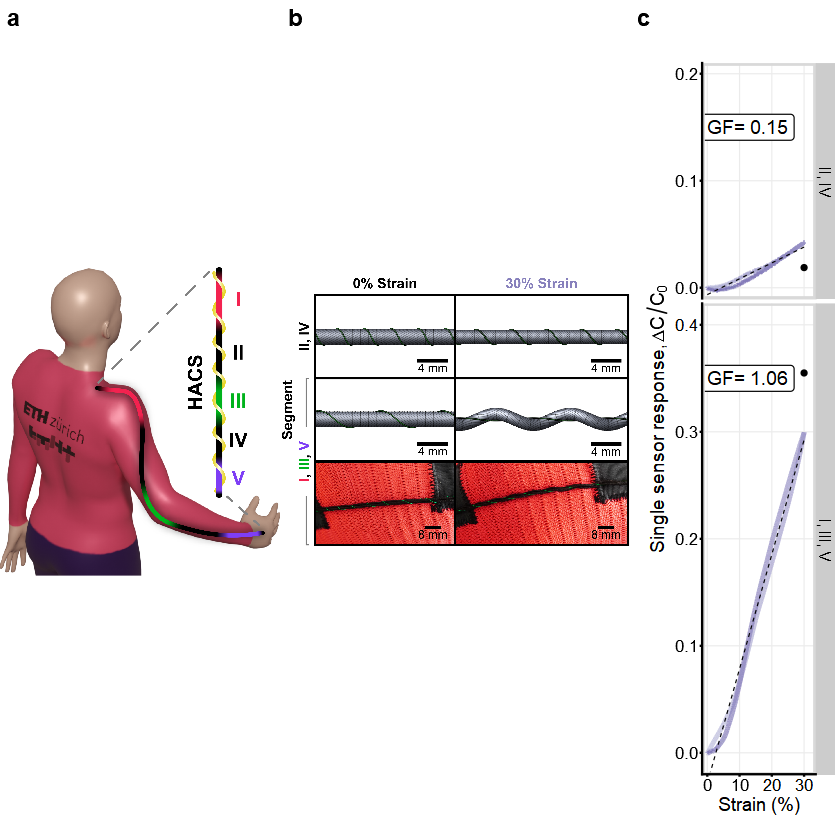

In [40]:
plot_grid(pose_render, sensor_models, plt1, nrow=1, rel_widths=c(2, 2.5, 1.5), scale=c(1, 1, 0.95), labels=c("a", "b", "c"), align="t")
ggsave('Fig2.png', width=180, height=68, units="mm", scale=1.5, bg="white", dpi=600)
ggsave('Fig2.eps', width=180, height=68, units="mm", scale=1.5, bg="white", device=cairo_ps, fallback_resolution=600)